# Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [10]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

import unicodedata
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import urllib
import requests
from nltk.corpus import stopwords 
import string 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier,\
            ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB

In [11]:
pd.set_option('display.max_colwidth', 1000)
path = "Data/train_tweets.csv"
tweetData = pd.read_csv(path, sep=',', encoding='UTF-8')
tweetData.drop(labels= 'id', axis=1, inplace= True)

# Data Visualization

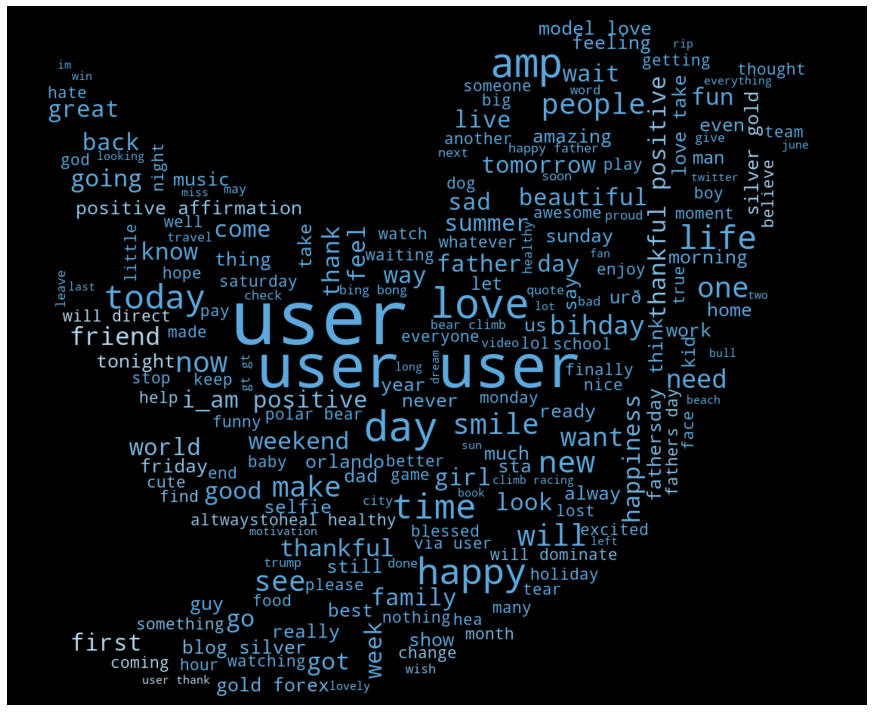

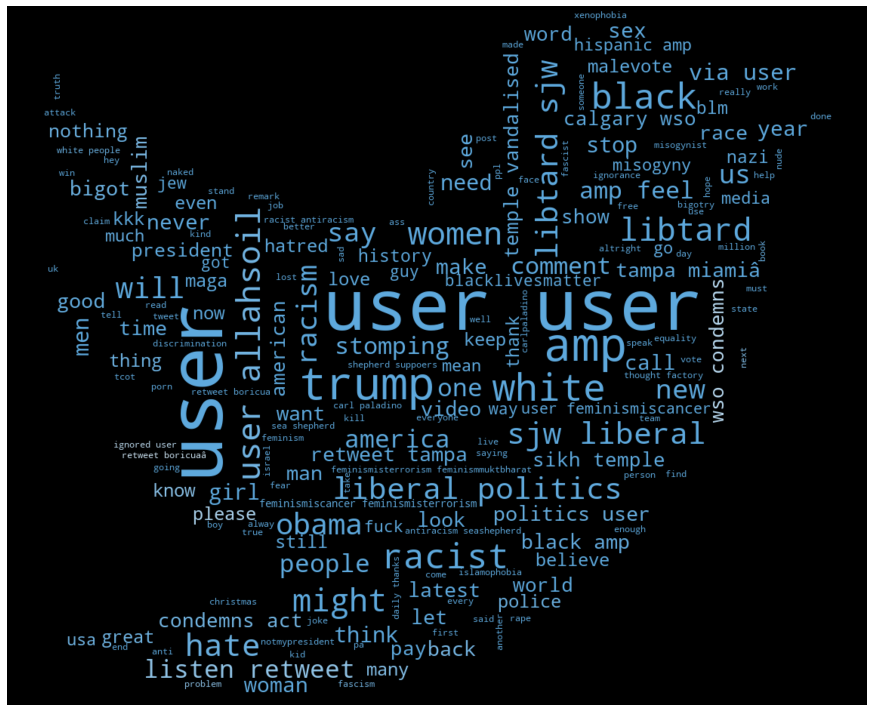

In [14]:
sentiment_possitive = ' '.join([word for word in tweetData.loc[tweetData['label']==0, 'tweet']])
sentiment_negative = ' '.join([word for word in tweetData.loc[tweetData['label']==1, 'tweet']])

sentiments = {'possitive':sentiment_possitive, 'negative':sentiment_negative}

def create_wordcloud(sentiments):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wordcloud = WordCloud(background_color='black',
                         max_font_size = 100, width=800, height=400, mask=Mask)
    
    for key  in sentiments:
        wordcloud.generate(sentiments[key])
        plt.figure(figsize=(15,10))
        plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="hamming")
        plt.axis('off')
        plt.savefig(str(key))
        plt.show()

create_wordcloud(sentiments)

# Pre-processing

In [15]:
newStopWords = ['thi','amp','if','sjw','user','co']
stop_words = stopwords.words(fileids='english')
stop_words.extend(newStopWords)

In [16]:
def remove_pattern(input_txt, pattern):
    txt = re.sub(pattern, " ", input_txt)
    return txt

In [17]:
def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], r"@[\w]*")
    dataframe['cleaned'] = dataframe['cleaned'].str.replace("[^a-zA-Z#]", " ")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe

In [18]:
tweetDataCleaned = preprocess(tweetData)
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take time ur
4,0,factsguide: society now #motivation,factsguide society motivation


# Checking class imbalance

Counter({0: 29720, 1: 2242})


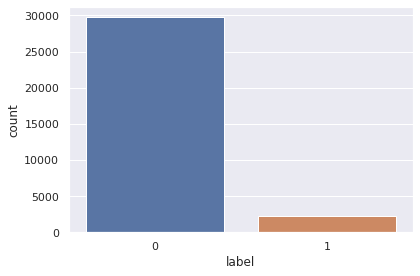

In [22]:
import collections

sentiment_counter = collections.Counter(tweetDataCleaned['label'])
print(sentiment_counter)

sns.set(style='darkgrid')
cp = sns.countplot(x='label', data=tweetDataCleaned)

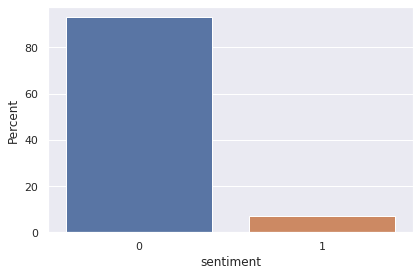

In [23]:
ax = sns.barplot(x='label',y='label', estimator=lambda x: len(x) / len(tweetDataCleaned) * 100, data=tweetDataCleaned)
ax.set(ylabel='Percent', xlabel='sentiment')
fig = ax.get_figure()
fig.savefig("cls.png")

In [16]:
#tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x:" ".join([word for word in x.split() if len(word)>3]))
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x: word_tokenize(x))
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,"[father, dysfunctional, selfish, drag, kid, dysfunction, run]"
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,"[thanks, lyft, credit, use, cause, offer, wheelchair, van, pdx, disapointed, getthanked]"
2,0,bihday your majesty,"[bihday, majesty]"
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,"[model, love, take, time, ur]"
4,0,factsguide: society now #motivation,"[factsguide, society, motivation]"


In [17]:
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x: ' '.join([word for word in x]))
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take time ur
4,0,factsguide: society now #motivation,factsguide society motivation


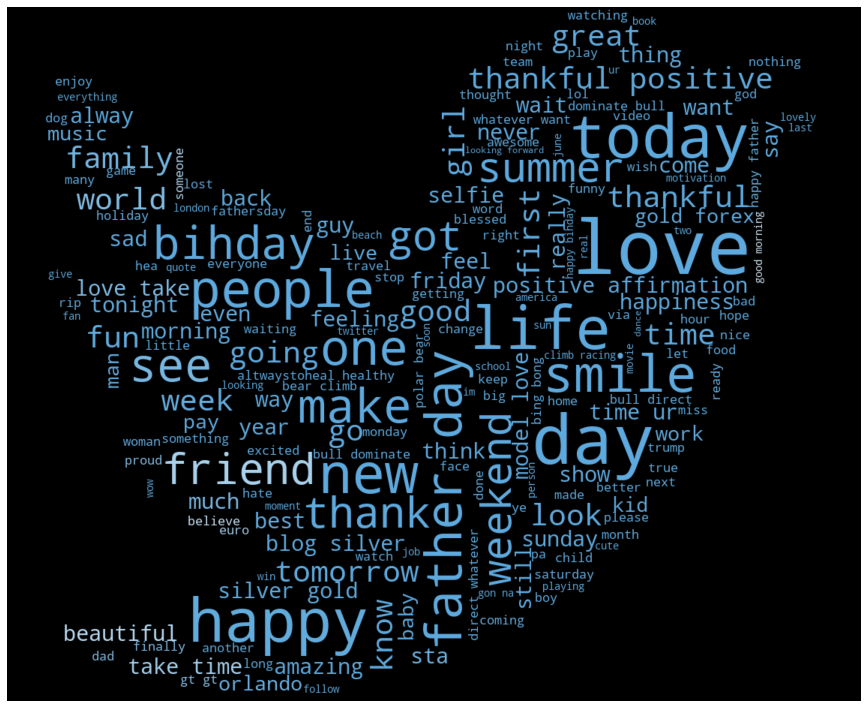

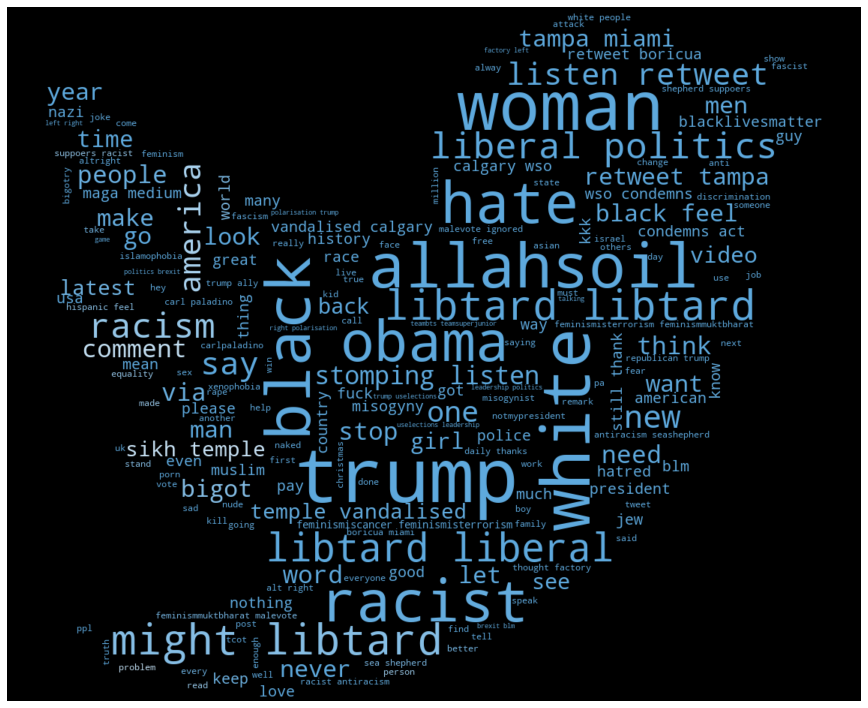

In [18]:
sentiment_possitive = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==0, 'cleaned']])
sentiment_negative = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==1, 'cleaned']])

sentiments = {"possitive":sentiment_possitive, "negative":sentiment_negative}

create_wordcloud(sentiments)

# bag-of-word

In [19]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(tweetDataCleaned['cleaned'])

df_bow = pd.DataFrame(bow.todense())

#df_bow

# TF-IDF

In [20]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(tweetDataCleaned['cleaned'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

#df_tfidf

# Splitting our dataset into Training and Validation Set

## Bag-of-words

In [21]:
train = tweetDataCleaned.iloc[:21308,0]
train_bow = bow[:21308]
train_bow.todense()
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,train,test_size=0.3,random_state=2)

## TF-IDF

In [22]:
train_tfidf_matrix = tfidf_matrix[:21308]
train_tfidf_matrix.todense()
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train,test_size=0.3,random_state=17)

# Supervised Machine Learning

### Logistic regression

In [30]:
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
Log_Reg_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(Log_Reg_tfidf))
print('Model - '+str(Log_Reg))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5965
           1       0.87      0.27      0.41       428

    accuracy                           0.95      6393
   macro avg       0.91      0.63      0.69      6393
weighted avg       0.94      0.95      0.94      6393

accuracy_score:0.9485374628499922
Model - LogisticRegression(random_state=0)
Confusion Matrix:


array([[5948,   17],
       [ 312,  116]])

### Decision Tree Classifier

In [32]:
dec_tree = DecisionTreeClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=4)
dec_tree.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = dec_tree.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
dec_tree_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(dec_tree_tfidf))
print('Model - '+str(dec_tree))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5965
           1       0.51      0.12      0.20       428

    accuracy                           0.93      6393
   macro avg       0.73      0.56      0.58      6393
weighted avg       0.91      0.93      0.91      6393

accuracy_score:0.9335210386360081
Model - DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=0)
Confusion Matrix:


array([[5915,   50],
       [ 375,   53]])

### RandomForestClassifier

In [33]:
ran_forest = RandomForestClassifier(class_weight="balanced", random_state=0,criterion="entropy", 
                               max_depth=5, max_samples=200)
ran_forest.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = ran_forest.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.45
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
ran_forest_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(ran_forest_tfidf))
print('Model - '+str(ran_forest))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5965
           1       0.53      0.44      0.48       428

    accuracy                           0.94      6393
   macro avg       0.75      0.71      0.73      6393
weighted avg       0.93      0.94      0.93      6393

accuracy_score:0.9366494603472548
Model - RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_samples=200, random_state=0)
Confusion Matrix:


array([[5798,  167],
       [ 238,  190]])

### MultinomialNB

In [34]:
mnb = MultinomialNB(alpha=1.0, fit_prior=False)
mnb.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = mnb.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
mnb_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(mnb_tfidf))
print('Model - '+str(mnb))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      5965
           1       0.29      0.78      0.42       428

    accuracy                           0.86      6393
   macro avg       0.64      0.82      0.67      6393
weighted avg       0.94      0.86      0.89      6393

accuracy_score:0.8585953386516503
Model - MultinomialNB(fit_prior=False)
Confusion Matrix:


array([[5157,  808],
       [  96,  332]])

## Ensemble

In [36]:
model = VotingClassifier(estimators=[('lr',Log_Reg),('mnb',mnb)], voting='soft')
model.fit(x_train_tfidf,y_train_tfidf)
prediction_int = model.predict(x_valid_tfidf)

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
model_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(model_tfidf))
print('Model - '+str(model))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5965
           1       0.63      0.53      0.58       428

    accuracy                           0.95      6393
   macro avg       0.80      0.75      0.77      6393
weighted avg       0.94      0.95      0.95      6393

accuracy_score:0.9480681995933051
Model - VotingClassifier(estimators=[('lr', LogisticRegression(random_state=0)),
                             ('mnb', MultinomialNB(fit_prior=False))],
                 voting='soft')
Confusion Matrix:


array([[5835,  130],
       [ 202,  226]])

# Prediction of new data

In [11]:
testData = pd.read_csv("Data/test_tweets.csv")

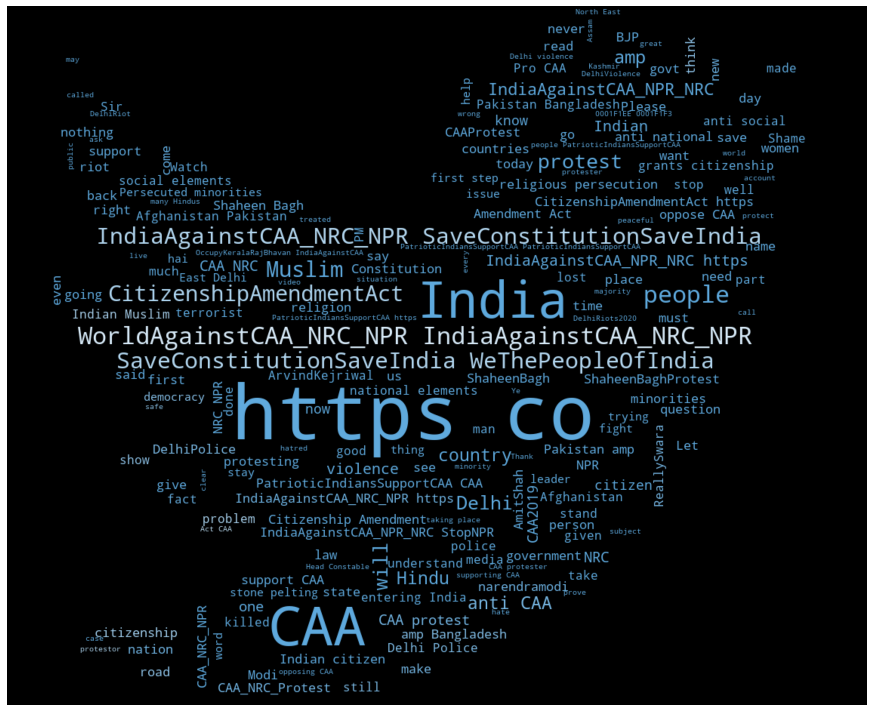

In [12]:
tweetswords = ' '.join([word for word in testData.loc[:, 'tweet']])
sentiments = {'before_cleaning':tweetswords}
create_wordcloud(sentiments)

In [14]:
testDataCleaned = preprocess(testData)
testDataCleaned.head(4)

,tweet,cleaned
0,"@TheQuint @shadabmoizee All #CAA_NRC_NPR Protests by Muslims incited by Congress &amp; Communists for allowing illegal immigrants from Pakistan, Bangladesh &amp; Myanmar into india is wrong since the #CitizenshipAmendmentAct was passed both in RAJYA SABHA &amp; LOK SABHA. https://t.co/6LKhvw27yk",all #caa nrc npr protests by muslims incited by congress amp communists for allowing illegal immigrants from pakistan bangladesh amp myanmar into india is wrong since the #citizenshipamendmentact was passed both in rajya sabha amp lok sabha
1,"@jijoy_matt @sumanthraman #ISLAMOPHOBIA FACT:\r\n\r\nNon-Muslims must be educated on ""ISLAMIC SHARIA LAW &amp; DEMOGRAPHIC JIHAD"" to know the Anti-Muslim Law in #CitizenshipAmendmentAct.\r\n\r\nSEPARATE RELIGION &amp; STATE FOR SECULAR UNIFORM CIVIL CODE.\r\n\r\ncc: @rashtrapatibhvn @VPSecretariat @PMOIndia @HMOIndia @amitmalviya https://t.co/HWoyE3obc2",#islamophobia fact non muslims must be educated on islamic sharia law amp demographic jihad to know the anti muslim law in #citizenshipamendmentact separate religion amp state for secular uniform civil code cc
2,"@BernieSanders @POTUS @realDonaldTrump @OIC_OCI @PeteButtigieg @ewarren @UKParliament @BorisJohnson @KremlinRussia_E @JustinTrudeau @georgesoros @OpenSociety @USCIRF must see india's Anti-Muslim #CitizenshipAmendmentAct while keeping in mind ""HUMANITY'S GOLDEN RULE OF TREATING OTHERS LIKE YOU ARE TREATED"" \r\n\r\nISLAMIC SHARIA ILL TREATS NON-MUSLIMS AS KAFIRS\r\nhttps://t.co/jU7S3f71Pj\r\n\r\n @HMOIndia @AmitShah @DrSJaishankar @MEAIndia @MEAIndia https://t.co/lQ2IWm83n2",must see india s anti muslim #citizenshipamendmentact while keeping in mind humanity s golden rule of treating others like you are treated islamic sharia ill treats non muslims as kafirs
3,Three\r\n\r\nA lone flag flutters\r\nIn a city charred by winds\r\nThus nation prevails\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram #poetry… https://t.co/2A0b30YjCc,three a lone flag flutters in a city charred by winds thus nation prevails #delhi #citizenshipamendmentact #delhiprotest #delhiviolence #haiku #travelhaiku #haikugram #micropoetry #writersofinstagram #poetry


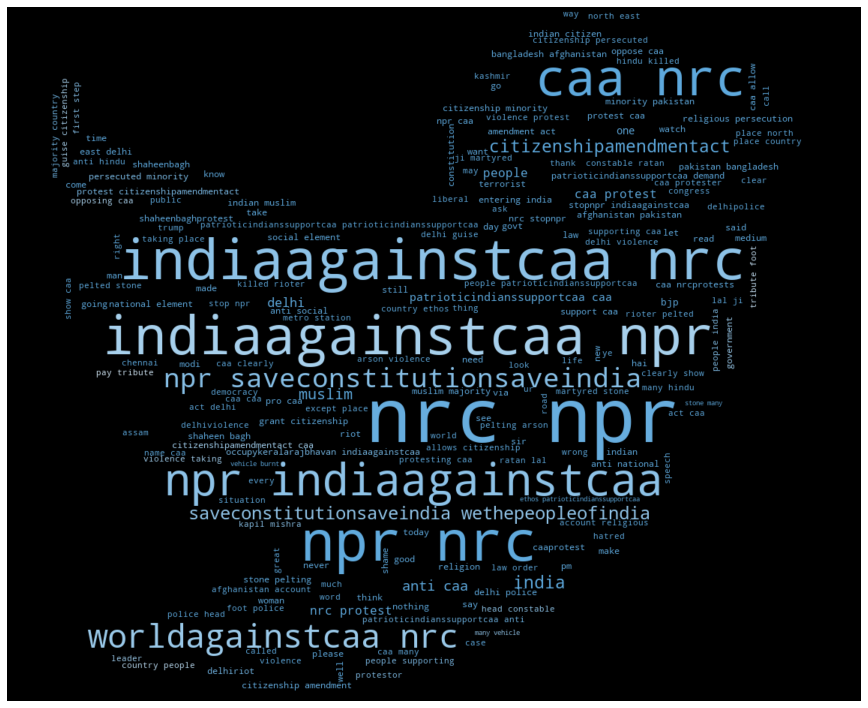

In [30]:
tweetswords = ' '.join([word for word in testDataCleaned.loc[:, 'cleaned']])
sentiments = {'after_cleaning':tweetswords}
create_wordcloud(sentiments)

### Bag of words

In [61]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(testDataCleaned['cleaned'])
df_bow = pd.DataFrame(bow.todense())

prediction_bow = model.predict_proba(bow)
prediction_bow

# if prediction is greater than or equal to 0.3 then 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.25

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)
prediction_int

array([1, 0, 0, ..., 0, 0, 0])

In [79]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')
tfidf_matrix=tfidf.fit_transform(testDataCleaned['cleaned'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())

prediction_int = model.predict(tfidf_matrix)
prediction_int

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission_unbalanced = pd.DataFrame({'tweet_id':testDataCleaned['tweet'],'Sentiment':prediction_int})
submission_unbalanced.to_csv('submission_unbalanced.csv', index=False)
print(submission_unbalanced.shape)
submission_unbalanced.head()

(5639, 2)


,tweet_id,Sentiment
0,"@TheQuint @shadabmoizee All #CAA_NRC_NPR Protests by Muslims incited by Congress &amp; Communists for allowing illegal immigrants from Pakistan, Bangladesh &amp; Myanmar into india is wrong since the #CitizenshipAmendmentAct was passed both in RAJYA SABHA &amp; LOK SABHA. https://t.co/6LKhvw27yk",0
1,"@jijoy_matt @sumanthraman #ISLAMOPHOBIA FACT:\r\n\r\nNon-Muslims must be educated on ""ISLAMIC SHARIA LAW &amp; DEMOGRAPHIC JIHAD"" to know the Anti-Muslim Law in #CitizenshipAmendmentAct.\r\n\r\nSEPARATE RELIGION &amp; STATE FOR SECULAR UNIFORM CIVIL CODE.\r\n\r\ncc: @rashtrapatibhvn @VPSecretariat @PMOIndia @HMOIndia @amitmalviya https://t.co/HWoyE3obc2",0
2,"@BernieSanders @POTUS @realDonaldTrump @OIC_OCI @PeteButtigieg @ewarren @UKParliament @BorisJohnson @KremlinRussia_E @JustinTrudeau @georgesoros @OpenSociety @USCIRF must see india's Anti-Muslim #CitizenshipAmendmentAct while keeping in mind ""HUMANITY'S GOLDEN RULE OF TREATING OTHERS LIKE YOU ARE TREATED"" \r\n\r\nISLAMIC SHARIA ILL TREATS NON-MUSLIMS AS KAFIRS\r\nhttps://t.co/jU7S3f71Pj\r\n\r\n @HMOIndia @AmitShah @DrSJaishankar @MEAIndia @MEAIndia https://t.co/lQ2IWm83n2",0
3,Three\r\n\r\nA lone flag flutters\r\nIn a city charred by winds\r\nThus nation prevails\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram #poetry… https://t.co/2A0b30YjCc,0
4,Five\r\n\r\nShivering squirrels\r\nWithin withering tree trunks\r\nDo not make a noise\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence #resist\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram… https://t.co/IChVLOFHdv,0
